In [1]:
import os
from tqdm import tqdm
import numpy as np
import zipfile
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
def img_resize(files,path):
    img_to_numpy = []
    for file in tqdm(files):
        file_img = PIL.Image.open(f"{path}/{file}")
        file_img = file_img.resize((256,256))
        img_to_numpy.append(np.array(file_img))
    return np.array(img_to_numpy)

### Data Preporcessing
* Unzip Data
* Resize to 256*256
* Pick Random Sample 512

In [ ]:
#  Load Dataset and Unzip
base_path = '/kaggle/input/dogs-vs-cats'
filelist = os.listdir('/kaggle/input/dogs-vs-cats')
for _file in filelist:
    if '.zip' in _file:
        with zipfile.ZipFile(os.path.join(base_path, _file), 'r') as z:
            z.extractall('/kaggle/working')

In [4]:
print(os.listdir('/kaggle/working'))

['train', 'test1', '.virtual_documents', '__notebook_source__.ipynb']


In [5]:
# Split Cat and Dog
train_files = os.listdir("/kaggle/working/train")
cat_files = sorted([file for file in train_files if file.split(".")[0] == "cat"], key=lambda x: int(x.split(".")[1]))
dog_files = sorted([file for file in train_files if file.split(".")[0] == "dog"], key=lambda x: int(x.split(".")[1]))

In [12]:
# Random Sampling 512 imgs
# needs Seed Setting
np.random.seed(42)
cat_random_sample = np.random.choice(cat_files, 512)
dog_random_sample = np.random.choice(dog_files, 512)
print(f"cat img count {cat_random_sample.shape}, dog img count {dog_random_sample.shape}")

cat img count (512,), dog img count (512,)


In [13]:
# Image Resize
numpy_cat = img_resize(cat_random_sample, "/kaggle/working/train")
numpy_dog = img_resize(dog_random_sample, "/kaggle/working/train")

100%|██████████| 512/512 [00:01<00:00, 265.17it/s]


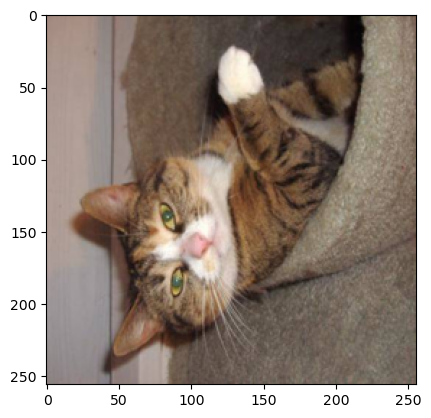

In [14]:
# Show Img to test
plt.imshow(numpy_cat[7])

In [ ]:
# 전체적인 모델 구조 수정 필요
# 
class conv_vae(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        # encoder
        self.e_conv2d_1 = nn.Conv2d(3, 32, kernel_size = 3, stride = (2, 2))
        self.e_conv2d_2 = nn.Conv2d(32, 64, kernel_size = 3, stride = (2, 2))
        self.e_conv2d_3 = nn.Conv2d(64, 128, kernel_size = 3, stride = (2, 2))
        self.e_conv2d_4 = nn.Conv2d(128, 256, kernel_size = 3, stride = (2, 2))
        self.e_Linear_1 = nn.Linear(256*15*15, self.latent_dim + self.latent_dim)
        
        # decoder
        self.d_Linear_1 = nn.Linear(self.latent_dim, 256*16*16)
        self.d_conv2d_1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.d_conv2d_2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        self.d_conv2d_3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0)
        self.d_conv2d_4 = nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2, padding=0)

    def encoder(self, x):
        # TensorShape([2, 3, 256, 256]) channel X height X width
        # First CNN
        # Encoder Conv2D_1 -------> torch.Size([2, 32, 127, 127])
        x = self.e_conv2d_1(x)
        x = nn.ReLU()(x)
        # Second CNN
        # Encoder Conv2D_2 -------> torch.Size([2, 64, 63, 63])
        x = self.e_conv2d_2(x)
        x = nn.ReLU()(x)
        # Third CNN
        # Encoder Conv2D_3 -------> torch.Size([2, 128, 31, 31])
        x = self.e_conv2d_3(x)
        x = nn.ReLU()(x)
        # Fourth CNN
        # Encoder Conv2D_4 ------->torch.Size([2, 256, 15, 15])
        x = self.e_conv2d_4(x)
        x = nn.ReLU()(x)
        x = nn.Flatten()(x)
        # Flatten, Dense -------> torch.Size([2, 4])
        x = self.e_Linear_1(x)
        return x
    
    def decoder(self, x):
        # Decoder Linear -------> torch.Size([2, 65536])
        x = self.d_Linear_1(x)
        # Decoder reshape -------> torch.Size([2, 256, 16, 16])
        x = x.reshape(-1, 256,16,16)
        # Decoder Conv2D_1 -------> torch.Size([2, 128, 32, 32])
        x = self.d_conv2d_1(x)
        x = nn.ReLU()(x)
        # Decoder Conv2D_2 -------> torch.Size([2, 64, 64, 64])
        x = self.d_conv2d_2(x)
        x = nn.ReLU()(x)
        # Decoder Conv2D_3 -------> torch.Size([2, 32, 128, 128])
        x = self.d_conv2d_3(x)
        x = nn.ReLU()(x)
        # NO Activation
        # Decoder Conv2D_4 -------> torch.Size([2, 3, 256, 256])
        x = self.d_conv2d_4(x)
        return x
    
    def encode(self, x):
        mean, logvar = torch.split(torch.Tensor(x), split_size_or_sections=2, dim = 1) 
        return mean, logvar
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        return logits
    
    def reparameterize(self, mean, logvar):
        eps = torch.normal(mean=0.0, std=torch.ones(mean.size()))
        return eps * torch.exp(logvar*0.5) + mean
    
    def sample(self, eps=None):
        if eps is None:
            eps = torch.normal(mean=0.0, std = torch.ones([100, self.latent_dim]))
        return self.decode(eps, apply_sigmoid=True)

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = torch.log(torch.Tensor([2*np.pi])).item()
    return torch.sum(
        -0.5 * ((sample-mean) ** 2 * torch.exp(-logvar) + logvar + log2pi), 
    axis = raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = nn.BCEWithLogitsLoss(reduction='none')(x_logit, x)
    logpx_z = -torch.sum(cross_ent, axis=[1, 2, 3])
    logpz = model.log_normal_pdf(z, 0., 0.)
    logqz_x = model.log_normal_pdf(z, mean, logvar)
    return -torch.sum(logpx_z + logpz - logqz_x)

In [ ]:
def training(model, train_dataloader, compute_loss, optimizer, device):
    train_loss = 0.0

    model.train()
    for x in train_dataloader:
        optimizer.zero_grad()
        loss = model(x.to(device))
        torch.sum(loss).backward()
        optimizer.step()
        train_loss += torch.sum(loss).item()
    return train_loss

def validation(model, val_dataloader, loss_fn, device):
    val_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for x in val_dataloader:
            loss = model(x.to(device))
            val_loss += torch.sum(loss).item()
    return val_loss

In [ ]:
def train_process(epochs, model, optimizer, train_dataloader, val_dataloader, device):
    best_loss, patience = float('inf'), 0
    
    # make ckpt saving directory 
    if not os.path.exists('/kaggle/working/ckpt'):
        os.makedirs('/kaggle/working/ckpt', exist_ok=True)
        
    for epoch in range(epochs):
        train_st_time=time.time()
        train_loss = training(model, train_dataloader, loss_fn, optimizer, device)
        val_loss = validation(model, val_dataloader, loss_fn, device)
        
        if val_loss < best_loss:
            patience = 0
            best_loss = val_loss
            ckpt_path = '/kaggle/working/ckpt/ft_transformer_encoder.pt'
#             torch.save(model.module.state_dict(), ckpt_path)
            torch.save(model.state_dict(), ckpt_path)
            
        elif val_loss >= best_loss:
            patience += 1
            if patience == 10:
                break
                print(f'Eearly Stopped {epoch}')
#         print(f'epoch: {epoch:3d}, train loss: {train_loss:8.4f}, valid loss: {val_loss:8.4f}, train f1 score: {train_f1*100:8.4f}, val f1 score: {val_f1*100:8.4f}, patience: {patience:2d}, time: {(time.time()-train_st_time):5.2f}')
        print(f'epoch: {epoch:3d}, train loss: {train_loss:8.4f}, valid loss: {val_loss:8.4f}, patience: {patience:2d}, time: {(time.time()-train_st_time):5.2f}')


In [ ]:
train_data, test_data = train_test_split(np.concatenate((numpy_cat, numpy_dog)), test_size=0.2, random_state=42)
del train_files, cat_files, dog_files, cat_random_sample, dog_random_sample, numpy_cat, numpy_dog
gc.collect()

30

In [ ]:
train_data = torch.stack([transforms.ToTensor()(data) for data in train_data])
test_data = torch.stack([transforms.ToTensor()(data) for data in test_data])

train_dataloader = DataLoader(train_data.type(torch.float32), batch_size=256, shuffle=True)
val_dataloader = DataLoader(test_data.type(torch.float32), batch_size=256, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 1000
# model = nn.DataParallel(Custom_tf_encoder(16996, 128, 1)).to(device)
model = nn.DataParallel(conv_vae(2)).to(device) # used_word, embed_dim, nhead, encoder_layers, max_len=1000
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
train_process(epochs, model, optimizer, train_dataloader, val_dataloader, device)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


epoch:   0, train loss: 552809528.0000, valid loss: 137947512.0000, patience:  0, time: 16.98
epoch:   1, train loss: 552730484.0000, valid loss: 137929494.0000, patience:  0, time:  7.06
epoch:   2, train loss: 552651514.0000, valid loss: 137912328.0000, patience:  0, time:  7.33
epoch:   3, train loss: 552578792.0000, valid loss: 137896592.0000, patience:  0, time:  7.10
epoch:   4, train loss: 552511248.0000, valid loss: 137881988.0000, patience:  0, time:  7.16
epoch:   5, train loss: 552451064.0000, valid loss: 137868352.0000, patience:  0, time:  7.16
epoch:   6, train loss: 552392574.0000, valid loss: 137854898.0000, patience:  0, time:  7.13
epoch:   7, train loss: 552332812.0000, valid loss: 137840946.0000, patience:  0, time:  7.36
epoch:   8, train loss: 552270984.0000, valid loss: 137826074.0000, patience:  0, time:  7.20
epoch:   9, train loss: 552204164.0000, valid loss: 137810044.0000, patience:  0, time:  7.25
epoch:  10, train loss: 552129470.0000, valid loss: 13779126

* Tensorflow to Pytorch
* source: https://www.tensorflow.org/tutorials/generative/cvae?hl=ko